# Importing packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Installing UGent Panno Font

Before running there are a few steps that need to be taken.

Download this: https://www.ugent.be/intranet/nl/op-het-werk/communicatie/huisstijl-presentaties/huisstijl/panno-text.zip
Unzip 'panno-text.zip'

Open and unzip '150831-ugentpannotext-v300-truetype.zip'

Upload the 'UGentPannoText-Normal' to this drive in the local directory!!!! (on the left bar, click the folder-icon, upload the 'UGentPannoText-Normal')

In [ ]:
font_files = fm.findSystemFonts('.')

for font_file in font_files:
    fm.fontManager.addfont(font_file)
print(font_files)
plt.rc('font', family='UGent Panno Text')

['/content/UGentPannoText-SemiLight.ttf', '/content/UGentPannoText-SemiBold.ttf', '/content/UGentPannoText-Normal.ttf', '/content/UGentPannoText-Medium.ttf']


# Defining plot layout

In [ ]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Model definition

In [ ]:
def CNN_OHE(tax, epochsize):
  print('Initiating training, validation and testing on {tax} using CNN with One Hot Encoded sequences')
  
  class my_precious_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32, device='cpu')
        self.y = torch.tensor(y, dtype=torch.long, device='cpu') # torch.long = 부호있는 정수형, torch.float = 32비트 소수형 
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length


  # Load the existed Training & Validation & Testing Dataset
  base_path = '/content/drive/MyDrive/BachelorsProject/FinalModels/1AMBI/'

  # These files are all in my google drive
  TrainX = np.load(f'{base_path}Train_X_OHE1A.npy')
  TrainY = np.load(f'{base_path}Train_Y_{tax}1A.npy')
  TestX = np.load(f'{base_path}Test_X_OHE1A.npy')
  TestY = np.load(f'{base_path}Test_Y_{tax}1A.npy')
  ValX = np.load(f'{base_path}Validation_X_OHE1A.npy')
  ValY = np.load(f'{base_path}Validation_Y_{tax}1A.npy')
  print('Training, test and validation datasets are loaded...')

  class Multi_Fungi_Classifier(nn.Module):
    def __init__(self):
        super(Multi_Fungi_Classifier, self).__init__()
        # First layer
        # Input shape = (100, 4, 700) 
        # 100: Batch size, 4: # of nucleotide, 700: Length of the sequences 
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # Input shape = (100, 8, 350)
        self.dropout = nn.Dropout(p=0.25)
        self.fc = nn.Linear(8 * 350, len(np.unique(TrainY))) 

        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1) # flatten
        out = self.fc(out)
        return out
  
    print('Model constructed...')

  model = Multi_Fungi_Classifier()

  batches = 200

  # Dataset
  trainset = my_precious_dataset(TrainX, TrainY)
  valset = my_precious_dataset(ValX, ValY)
  testset = my_precious_dataset(TestX, TestY)

  # Dataloader
  trainloader = DataLoader(trainset, batch_size=batches, shuffle=True)
  valloader = DataLoader(valset, batch_size=batches, shuffle=False)
  testloader = DataLoader(testset, batch_size=batches, shuffle=False)  

  # Model Training
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  # Store the training loss and the accuracy
  training_losses = []
  training_accuracy = []

  # Store the validation loss and the accuracy
  validation_losses = []
  validation_accuracy = []
      
  print('Training model...')
  epochs = epochsize
  for epoch in range(epochs):
      model.train()
      training_loss = 0.0
      correct = 0 # 예측값이 맞은 횟수
      total = 0

      # x_train is input data for the batch, y_train is the labels
      for i, (x_train, y_train) in enumerate(trainloader):
          input = x_train.transpose(1, 2)
          output = model(input)                        # Output shape: torch.Size([100, 16])
          loss = loss_fn(output, y_train)

          # Add L2 regularization
          l2_reg = torch.tensor(0.)
          for param in model.parameters():
              l2_reg += torch.norm(param)
          loss += 0.001 * l2_reg

          # Back propagation - gradients are calculated and the optimizer updates
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Calculate training loss and accuracy
          training_loss += loss.item() * input.size(0) # multiply the loss with the batch size (100)
          _, predicted = torch.max(output.data, 1)     # 0은 행 (세로), 1은 열 (가로) 마다 최댓값의 위치를 예측값으로 사용하겠다는 의미! * 원래 torch.max 는 최댓값, 최댓값의 위치를 산출해주는데, 최댓값은 필요없으므로 _ 로 저장 x
          total += y_train.size(0)                     # Total number of predictions 
          correct += (predicted == y_train).sum().item() # 예측값과 라벨이 맞을때의 개수 * item()이 없으면 tensor(64) 라고 나옴. 

      # Print training statistics
      epoch_loss = training_loss / len(trainloader.dataset) # Training loss is calculated by dividing the cumulative loss by the total number of data points in the training dataset
      epoch_acc = 100. * correct / total   
      
      # Store the training loss and the accuracy
      training_losses.append(epoch_loss)
      training_accuracy.append(epoch_acc)
      
      # Validation
      model.eval()
      validation_loss = 0.0
      correct = 0
      total = 0
    
      with torch.no_grad():
        for i, (x_val, y_val) in enumerate(valloader):
            input = x_val.transpose(1, 2)
            output = model(input)
            loss = loss_fn(output, y_val)
            
            # Calculate validation loss and accuracy
            validation_loss += loss.item() * input.size(0)
            _, predicted = torch.max(output.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

      # Calculate validation loss and accuracy
      epoch_val_loss = validation_loss / len(valloader.dataset)
      epoch_val_acc = 100. * correct / total

      # Store the validation loss and the accuracy
      validation_losses.append(epoch_val_loss)
      validation_accuracy.append(epoch_val_acc)

      print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%, Validation Accuracy: {epoch_val_acc:.2f}%')

  # Set the model to evaluation mode
  model.eval()

  with torch.no_grad():
    y_prediction = []
    y_true = []

    for x_test, y_test in testloader:
      test_input = x_test.transpose(1, 2)
      test_output = model(test_input)
      y_prediction += torch.argmax(test_output, dim=1).tolist()
      y_true += y_test.tolist()
    print(metrics.classification_report(y_true, y_prediction, digits=3))     

  plt.plot(training_losses, label='Training', color='#1E64C8', linewidth=1)
  plt.plot(validation_losses, label='Validation', color='black', linewidth=1)
  plt.title(f'Training and Validation Loss of the CNN on {tax} level with OHE')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (in %)')
  plt.legend()
  plt.savefig(f'CNNOHE{tax}Loss1A.svg')
  files.download(f'CNNOHE{tax}Loss1A.svg') 
  plt.show()

  plt.plot(training_accuracy, label='Training', color='#1E64C8', linewidth=1)
  plt.plot(validation_accuracy, label='Validation', color='black', linewidth=1)
  plt.title(f'Training and Validation Accuracy of the CNN on {tax} level with OHE')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (in %)')
  plt.legend()
  plt.savefig(f'CNNOHE{tax}Accuracy1A.svg')
  files.download(f'CNNOHE{tax}Accuracy1A.svg') 
  plt.show()
  print(f'Training, validation and testing on {tax} level with OHE is completed.') 

# Phylum Level

Initiating training, validation and testing on {tax} using CNN with One Hot Encoded sequences
Training, test and validation datasets are loaded...
Model constructed...
Training model...
Epoch [1/120], Training Loss: 0.8995, Validation Loss: 0.6738, Training Accuracy: 67.18%, Validation Accuracy: 82.15%
Epoch [2/120], Training Loss: 0.5767, Validation Loss: 0.4803, Training Accuracy: 83.74%, Validation Accuracy: 86.86%
Epoch [3/120], Training Loss: 0.4359, Validation Loss: 0.3778, Training Accuracy: 87.46%, Validation Accuracy: 88.40%
Epoch [4/120], Training Loss: 0.3522, Validation Loss: 0.3088, Training Accuracy: 89.19%, Validation Accuracy: 90.04%
Epoch [5/120], Training Loss: 0.2937, Validation Loss: 0.2604, Training Accuracy: 90.72%, Validation Accuracy: 91.45%
Epoch [6/120], Training Loss: 0.2524, Validation Loss: 0.2243, Training Accuracy: 91.92%, Validation Accuracy: 92.53%
Epoch [7/120], Training Loss: 0.2222, Validation Loss: 0.1974, Training Accuracy: 92.84%, Validation Accur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

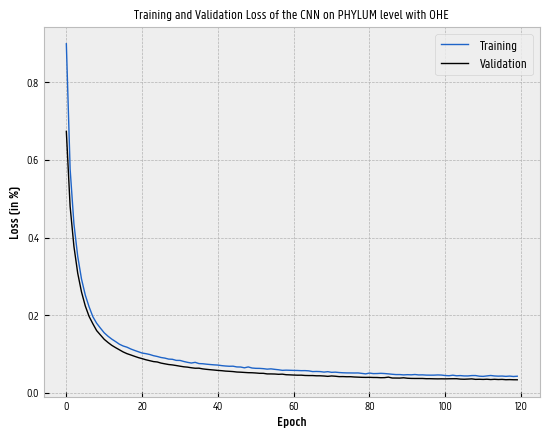

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

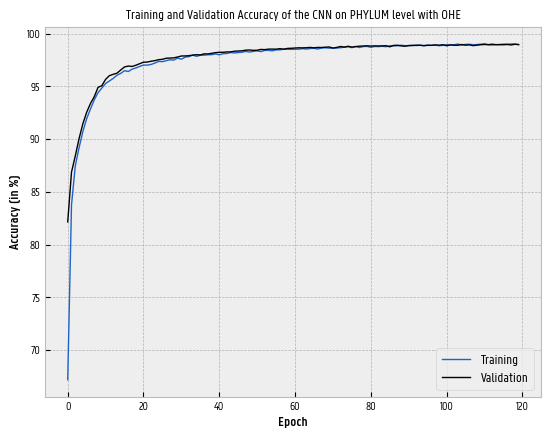

Training, validation and testing on PHYLUM level with OHE is completed.


In [ ]:
CNN_OHE('PHYLUM', 120)

# Class

Initiating training, validation and testing on {tax} using CNN with One Hot Encoded sequences
Training, test and validation datasets are loaded...
Model constructed...
Training model...
Epoch [1/140], Training Loss: 1.6008, Validation Loss: 1.3433, Training Accuracy: 54.92%, Validation Accuracy: 57.38%
Epoch [2/140], Training Loss: 1.2232, Validation Loss: 1.0960, Training Accuracy: 66.46%, Validation Accuracy: 73.22%
Epoch [3/140], Training Loss: 1.0140, Validation Loss: 0.9193, Training Accuracy: 75.45%, Validation Accuracy: 76.97%
Epoch [4/140], Training Loss: 0.8586, Validation Loss: 0.7822, Training Accuracy: 78.12%, Validation Accuracy: 79.65%
Epoch [5/140], Training Loss: 0.7343, Validation Loss: 0.6757, Training Accuracy: 80.36%, Validation Accuracy: 81.67%
Epoch [6/140], Training Loss: 0.6361, Validation Loss: 0.5879, Training Accuracy: 82.56%, Validation Accuracy: 83.72%
Epoch [7/140], Training Loss: 0.5588, Validation Loss: 0.5215, Training Accuracy: 84.66%, Validation Accur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

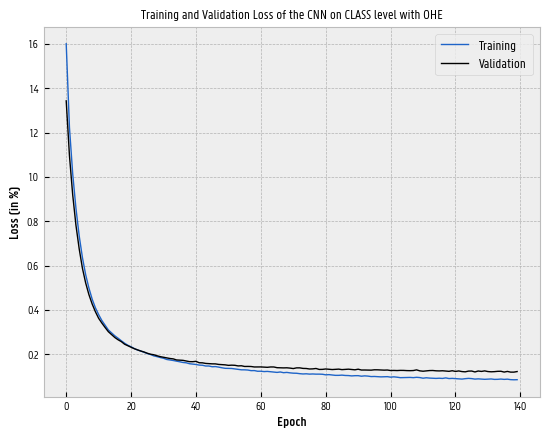

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

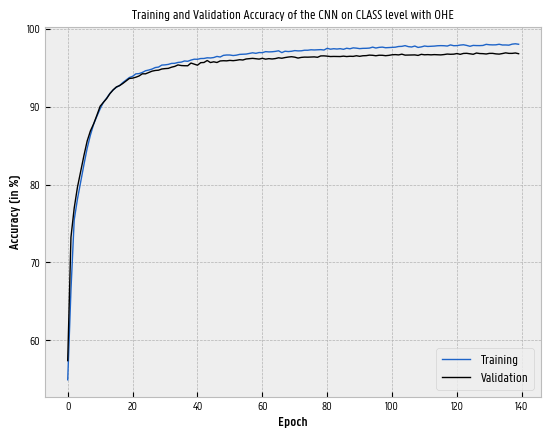

Training, validation and testing on CLASS level with OHE is completed.


In [ ]:
CNN_OHE('CLASS', 140)

# Order

Initiating training, validation and testing on {tax} using CNN with One Hot Encoded sequences
Training, test and validation datasets are loaded...
Model constructed...
Training model...
Epoch [1/160], Training Loss: 2.8330, Validation Loss: 2.3824, Training Accuracy: 27.47%, Validation Accuracy: 43.79%
Epoch [2/160], Training Loss: 2.1249, Validation Loss: 1.8570, Training Accuracy: 50.22%, Validation Accuracy: 56.60%
Epoch [3/160], Training Loss: 1.6792, Validation Loss: 1.4976, Training Accuracy: 60.41%, Validation Accuracy: 64.73%
Epoch [4/160], Training Loss: 1.3674, Validation Loss: 1.2467, Training Accuracy: 67.61%, Validation Accuracy: 70.41%
Epoch [5/160], Training Loss: 1.1482, Validation Loss: 1.0688, Training Accuracy: 73.25%, Validation Accuracy: 74.92%
Epoch [6/160], Training Loss: 0.9911, Validation Loss: 0.9415, Training Accuracy: 77.07%, Validation Accuracy: 78.37%
Epoch [7/160], Training Loss: 0.8750, Validation Loss: 0.8416, Training Accuracy: 79.65%, Validation Accur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

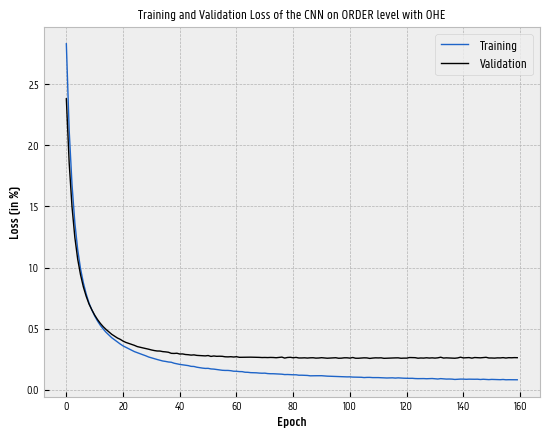

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

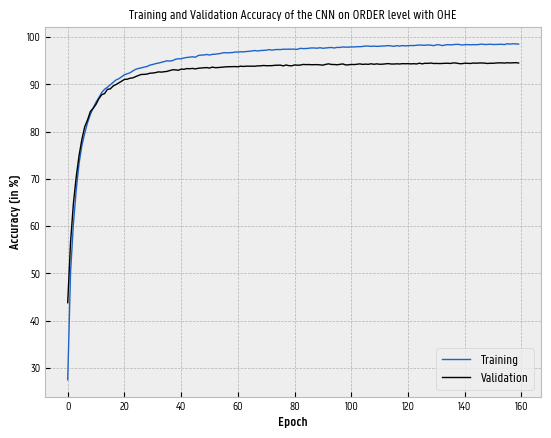

Training, validation and testing on ORDER level with OHE is completed.


In [ ]:
CNN_OHE('ORDER', 160)

# Family

Initiating training, validation and testing on {tax} using CNN with One Hot Encoded sequences
Training, test and validation datasets are loaded...
Model constructed...
Training model...
Epoch [1/180], Training Loss: 3.9017, Validation Loss: 3.4005, Training Accuracy: 18.30%, Validation Accuracy: 33.08%
Epoch [2/180], Training Loss: 3.0236, Validation Loss: 2.6781, Training Accuracy: 38.70%, Validation Accuracy: 43.80%
Epoch [3/180], Training Loss: 2.3844, Validation Loss: 2.1608, Training Accuracy: 50.28%, Validation Accuracy: 55.12%
Epoch [4/180], Training Loss: 1.9318, Validation Loss: 1.8019, Training Accuracy: 60.20%, Validation Accuracy: 62.85%
Epoch [5/180], Training Loss: 1.6143, Validation Loss: 1.5494, Training Accuracy: 66.88%, Validation Accuracy: 68.32%
Epoch [6/180], Training Loss: 1.3822, Validation Loss: 1.3632, Training Accuracy: 71.80%, Validation Accuracy: 72.23%
Epoch [7/180], Training Loss: 1.2128, Validation Loss: 1.2245, Training Accuracy: 75.37%, Validation Accur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

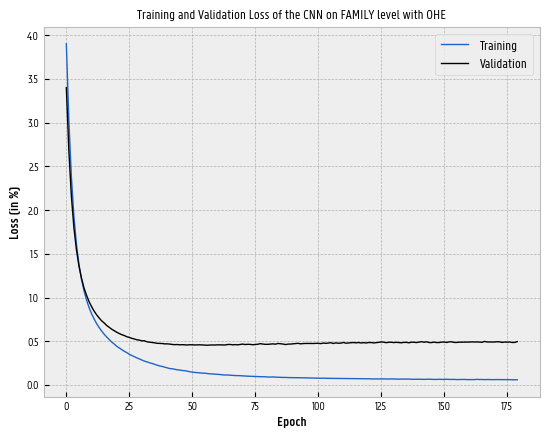

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

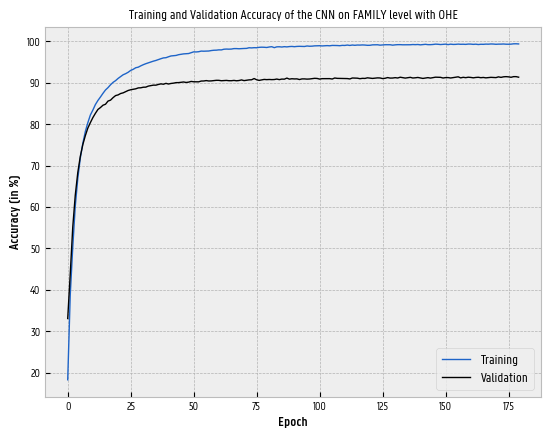

Training, validation and testing on FAMILY level with OHE is completed.


In [ ]:
CNN_OHE('FAMILY', 180)

# Genus

Initiating training, validation and testing on {tax} using CNN with One Hot Encoded sequences
Training, test and validation datasets are loaded...
Model constructed...
Training model...
Epoch [1/200], Training Loss: 4.4962, Validation Loss: 3.9801, Training Accuracy: 12.61%, Validation Accuracy: 26.12%
Epoch [2/200], Training Loss: 3.5491, Validation Loss: 3.1791, Training Accuracy: 32.09%, Validation Accuracy: 36.87%
Epoch [3/200], Training Loss: 2.7848, Validation Loss: 2.5235, Training Accuracy: 44.15%, Validation Accuracy: 48.97%
Epoch [4/200], Training Loss: 2.1995, Validation Loss: 2.0637, Training Accuracy: 55.68%, Validation Accuracy: 57.76%
Epoch [5/200], Training Loss: 1.7987, Validation Loss: 1.7590, Training Accuracy: 63.97%, Validation Accuracy: 63.90%
Epoch [6/200], Training Loss: 1.5246, Validation Loss: 1.5453, Training Accuracy: 69.22%, Validation Accuracy: 68.41%
Epoch [7/200], Training Loss: 1.3280, Validation Loss: 1.3919, Training Accuracy: 73.21%, Validation Accur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

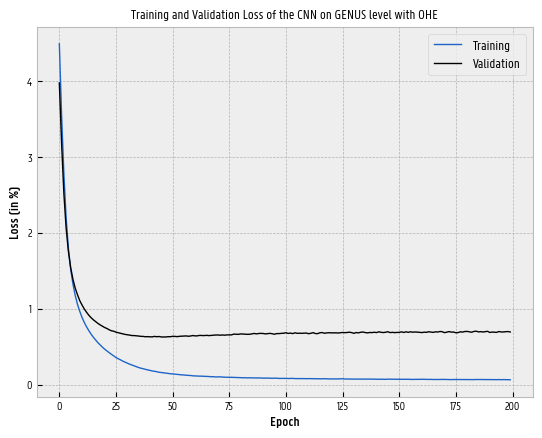

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

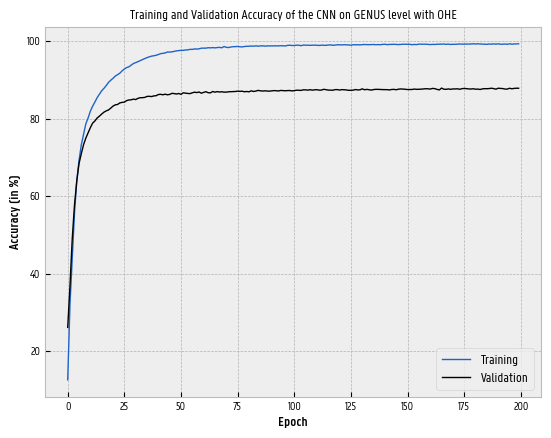

Training, validation and testing on GENUS level with OHE is completed.


In [ ]:
CNN_OHE('GENUS', 200)